# About me:



## Profile
**Name** : BVSG Suraj

**Batch** : 7

**Project** : Implement [Facial Expression Recognition](https://github.com/zlpure/Facial-Expression-Recognition) using winograd convolutions

## Current Status

Trying to implement Winograd convolutions in python by referring the paper : https://arxiv.org/abs/1509.09308

## Logs
* 16/6 : Implementing winograd convolutions for 2D data (WORKING)
* 14/6 : Performed EDA and some data pre-processing.
* 13/6 : Set up Jupyter Notebook.
* 12/6 : Understood Winograg Convolution.
* 10/6 : Started literature survey.

# Preliminary Setup


In [0]:
#Installing required libraries
!pip install -q keras
!pip install -q pathlib

In [0]:
#Linking drive to colab to store datasets
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

In [0]:
# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()

# Generate creds for the Drive FUSE library. Though the link asks you to verify twice, you don't have to!
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive

print ('Files in Drive:')
!ls drive/EIP/Facial_Expression_Recognition/

In [0]:
#Unpack datasets and copy back to drive. Just once at the beginning.
#!tar -xvf drive/EIP/Facial_Expression_Recognition/fer2013.tar.gz
!cp -a . drive/EIP/Facial_Expression_Recognition

# Run this only when starting a new session. Syncing files in drive to pwd.
#!cp -r drive/EIP/Facial_Expression_Recognition .
#!ls

# Environment specific Setup

In [11]:
#Framework related libraries
import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Concatenate
from keras.optimizers import Adam

##---------------------------------------------##

#For loading models
from pathlib import Path
from keras.models import load_model

##---------------------------------------------##

##Data preprocessing

#for class balance
from sklearn.utils import class_weight

#For data augmentation
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

##---------------------------------------------##

# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf
from keras import backend as k

##---------------------------------------------##

# Don't pre-allocate memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

##---------------------------------------------##

# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))

Using TensorFlow backend.


In [0]:
#Data handling libraries
import numpy as np
import pandas as spd

##---------------------------------------------##

#Image handling libraries
import matplotlib.pyplot as plt

##---------------------------------------------##

# This is a bit of magic to make matplotlib figures appear inline in the notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 8) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
%load_ext autoreload
%autoreload 2

# Exploratory Data Analysis



In [0]:
#Given data set is in csv format after unzipping.

file = 'drive/EIP/Facial_Expression_Recognition/fer2013/fer2013.csv'
df = spd.read_csv(file)

In [0]:
#Assign separate data frames to training, cross-validation and test data

#Training set
tr_set = df.loc[df['Usage'] == 'Training']
tr = tr_set.loc[:,'pixels']

#Cross-validation set
cv_set = df.loc[df['Usage'] == 'PublicTest']
cv = cv_set.loc[:,'pixels']

#Test set
te_set = df.loc[df['Usage'] == 'PrivateTest']
te = te_set.loc[:,'pixels']

Lets randomly sample 5 images of each emotion from training dtaset

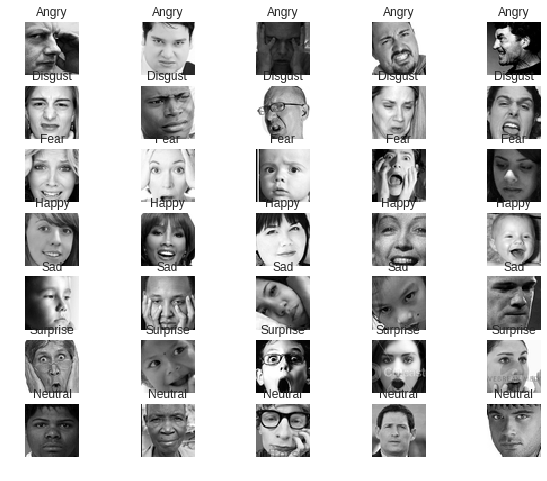

In [17]:
tr_set_emotions_label = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']

#size of each class will be stored in this array
t=np.zeros(np.size(tr_set_emotions_label)) 

#No. of images to sample from each class
sample_size=5

#Display those images
for k,e in enumerate(tr_set_emotions_label):
  this_emotion_set = df.loc[(df['Usage'] == 'Training') & (df['emotion'] == k)]
  t[k] = this_emotion_set.size
  x=this_emotion_set.sample(n=sample_size).loc[:,'pixels']
  for i,j in enumerate(x):
    plt.subplot(7, 5,(size*k)+i+1)
    y = j.split(' ')
    x = np.array(y).reshape(48,48)
    plt.axis('off')
    plt.grid('off')
    plt.imshow(x.astype('uint8'))
    plt.title(e)

## Inferences


1.   The data provided is flattened/unrolled. To display them, we have to roll or reshape the vectors.
2.   This dataset consists of faces of various expressions of all kinds of age, race and sex. That means the data is well generalized. 
3.   Faces in the images seemed to be centered. So, face detection and extraction can be skipped.
4.   Images are in grey scale. That means fewer parameters.
5.  Given the classes 'Surprise' and 'Happy', there might be high chance of misclassification. This is due to their high spatial corelation.

Let's explore data distribution among various classes

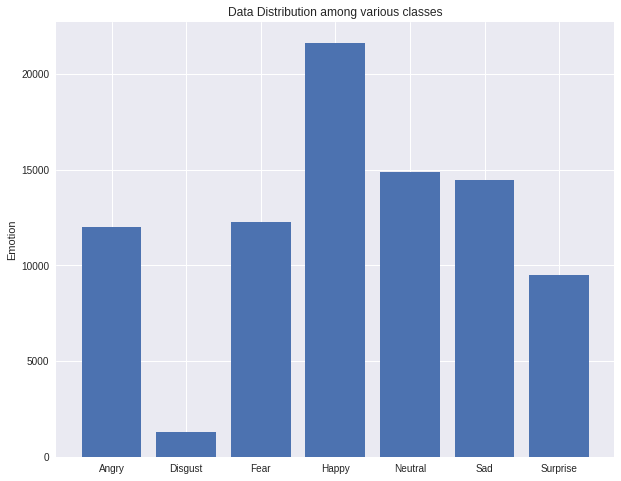

In [18]:
#Plotting no. of training examples vs their class
plt.bar(tr_set_emotions_label, t)
plt.ylabel('No. of training examples')
plt.ylabel('Emotion')
plt.title('Data Distribution among various classes')

plt.show()  

* It can be observed that the class 'Disgust' has very less number of training data. 

* And there is a high possibility of the model to predict 'Happy' if the training data isn't normalized.

* This problem can be solved in various ways:

  1.** Assigning weightage** for each class using Keras 'class_weight'. This is preferred.
  
  2.** Data augmentation** - Since the variation among the no. of training examples accross the classes is very high, using augmentation might not be a good idea. If we do that, there will be a rich variation in 'Happy' class and less variations in 'disgust' class and training over this data would be redundant. But applying Augmentation on all of the classes is a good idea.
  
  3.** Removing data** from other classes. Loss of data is not encouraged usually. 

  4.** Using GANs** : New training data can be created from the respective class's distribution. This is an option too.


**NOTE : The labels on the x-axis are not in order of the labels 0-7**

# Data Preprocessing


Class weights are assiged here.

In [24]:
#Finding the weightage to be given to each class
class_weights_array = np.round(np.max(t)/t)

class_weight = dict(zip(np.arange(np.size(t)), class_weights_array))

#print(class_weight)

{0: 2.0, 1: 17.0, 2: 2.0, 3: 1.0, 4: 1.0, 5: 2.0, 6: 1.0}
